In [1]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns 
import warnings
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
# load the dataset
microsoft = pd.read_csv(r"C:\Users\visha\Downloads\Microsoft_Stock.csv")
microsoft.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
# Drop columns that are not going to be used for predicting the stock prices
microsoft = microsoft.drop(columns={'Open','High','Low','Close'})
microsoft

,Date,Volume
0,4/1/2015 16:00:00,36865322
1,4/2/2015 16:00:00,37487476
2,4/6/2015 16:00:00,39223692
3,4/7/2015 16:00:00,28809375
4,4/8/2015 16:00:00,24753438
...,...,...
1506,3/25/2021 16:00:00,34061853
1507,3/26/2021 16:00:00,25479853
1508,3/29/2021 16:00:00,25227455
1509,3/30/2021 16:00:00,24792012


In [4]:
# Convert the format of the date
microsoft['Date'] = pd.to_datetime(microsoft['Date'])
microsoft.head()

,Date,Volume
0,2015-04-01 16:00:00,36865322
1,2015-04-02 16:00:00,37487476
2,2015-04-06 16:00:00,39223692
3,2015-04-07 16:00:00,28809375
4,2015-04-08 16:00:00,24753438


In [5]:
# Make the data column into an index for graphing a time series plot and delete the old date column
microsoft.index = microsoft['Date']
del microsoft['Date']
microsoft

,Volume
Date,
2015-04-01 16:00:00,36865322
2015-04-02 16:00:00,37487476
2015-04-06 16:00:00,39223692
2015-04-07 16:00:00,28809375
2015-04-08 16:00:00,24753438
...,...
2021-03-25 16:00:00,34061853
2021-03-26 16:00:00,25479853
2021-03-29 16:00:00,25227455


In [6]:
# Basic statistics of the microsoft stock dataset displayed below
microsoft.describe()

,Volume
count,1.511000e+03
mean,3.019863e+07
std,1.425266e+07
min,1.016120e+05
25%,2.136213e+07
50%,2.662962e+07
75%,3.431962e+07
max,1.352271e+08


In [7]:
# Determine the data type of the volume data
microsoft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Volume  1511 non-null   int64
dtypes: int64(1)
memory usage: 23.6 KB


In [8]:
# Remove any NaN values
microsoft_new = microsoft[np.isfinite(microsoft).all(1)]

In [9]:
# Observe the size of the data
microsoft_new.shape

(1511, 1)

In [10]:
# determine if there are any null values in the new dataset
microsoft_new.isna().sum()

Volume    0
dtype: int64

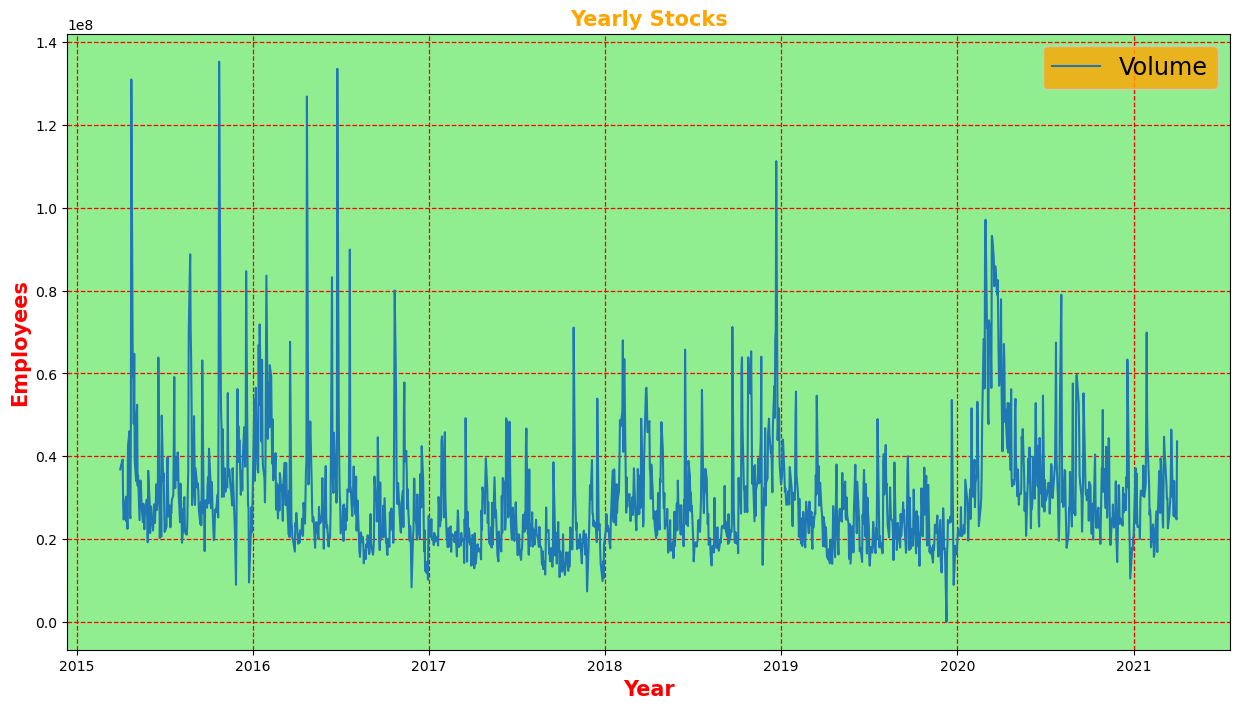

In [11]:
# plot a time series graph to analyze the volume of stocks occurring throughout each year
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(microsoft_new)
ax.set_xlabel("Year", fontweight = 'bold', color = 'red', size = 15)
ax.set_ylabel("Employees", fontweight = 'bold', color ='red', size = 15)
ax.set_title("Yearly Stocks", color = 'orange', fontweight = 'bold', size = 15)
ax.set_facecolor("lightgreen")
ax.legend(['Volume'],facecolor='orange', fontsize='xx-large')
plt.grid(color = 'red', linestyle = '--', linewidth = 0.9)
plt.show()

In [12]:
# calculate the mean of 10 previous cycle periods
# calculate the standard deviation of 10 previous cycle periods
rolling_mean = microsoft_new.rolling(10).mean()
rolling_std = microsoft_new.rolling(10).std()

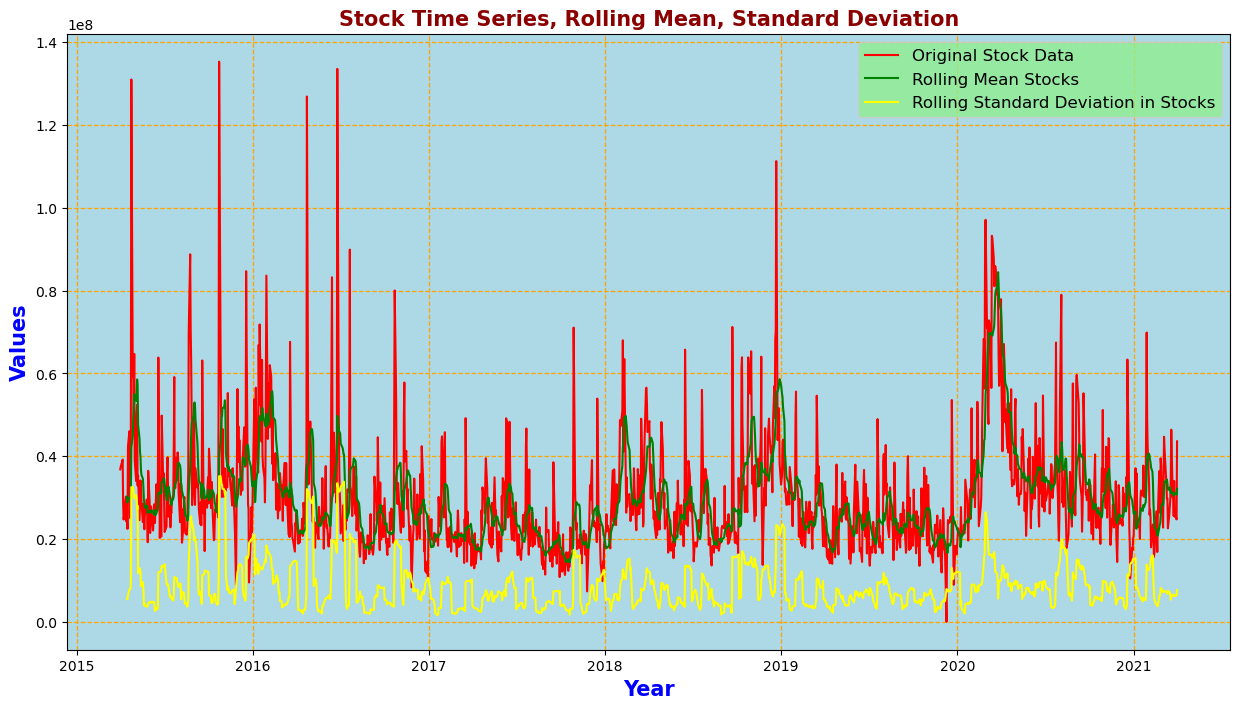

In [13]:
# plot the rolling mean, rolling standard deviation, and the original data for comparsion
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(microsoft_new, color="red",label="Original Stock Data")
ax.plot(rolling_mean, color="green", label="Rolling Mean Stocks")
ax.plot(rolling_std, color="yellow", label = "Rolling Standard Deviation in Stocks")
ax.set_title("Stock Time Series, Rolling Mean, Standard Deviation", color = 'darkred',fontweight = 'bold', size = 15)
ax.set_xlabel("Year", color = 'blue', fontweight = 'bold', size = 15)
ax.set_ylabel("Values", color = 'blue', fontweight = 'bold', size = 15)
ax.set_facecolor("lightblue")
plt.grid(color = 'orange', linestyle = '--', linewidth = 0.9)
ax.legend(facecolor='lightgreen', fontsize='large')

In [14]:
# Compare the fit of different regression model
adft = adfuller(microsoft_new,autolag="AIC")

In [15]:
# Store the results in a dataframe and print it out for intrepretation
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -6.899656e+00              Test Statistics
1  1.291812e-09                      p-value
2  8.000000e+00             No. of lags used
3  1.502000e+03  Number of observations used
4 -3.434711e+00          critical value (1%)
5 -2.863466e+00          critical value (5%)
6 -2.567795e+00         critical value (10%)


In [16]:
# calculate the autocorrelation with a one month period
autocorrelation_lag1 = microsoft_new['Volume'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.6353964862047757


In [17]:
# calculate the autocorrelation with a three month period
autocorrelation_lag3 = microsoft_new['Volume'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

# calculate the autocorrelation with a six month period
autocorrelation_lag6 = microsoft_new['Volume'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

# calculate the autocorrelation with a nine month period
autocorrelation_lag9 = microsoft_new['Volume'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = microsoft_new['Volume'].autocorr(lag=12)
print("Twelveth Month Lag: ", autocorrelation_lag12)

Three Month Lag:  0.4449136935404141
Six Month Lag:  0.3316355431611336
Nine Month Lag:  0.31907218185737746
Twelveth Month Lag:  0.2650247394033342


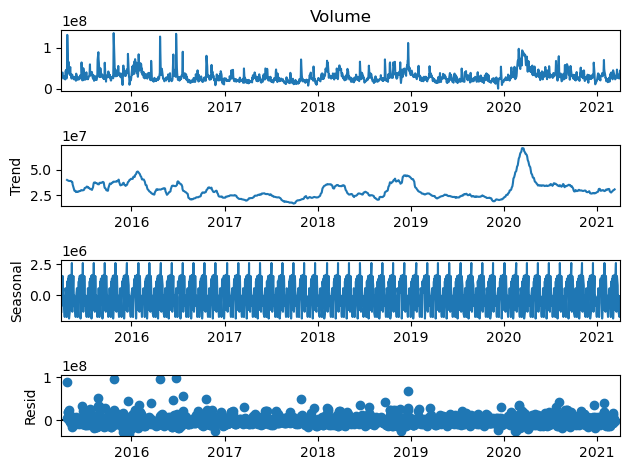

In [18]:
# visualize several trends using the trend decomposition method
decompose = seasonal_decompose(microsoft_new['Volume'],model='additive', period=30)
decompose.plot()
plt.show()

In [19]:
# Observe the last previous cycles
microsoft_new.tail()

,Volume
Date,
2021-03-25 16:00:00,34061853
2021-03-26 16:00:00,25479853
2021-03-29 16:00:00,25227455
2021-03-30 16:00:00,24792012
2021-03-31 16:00:00,43623471


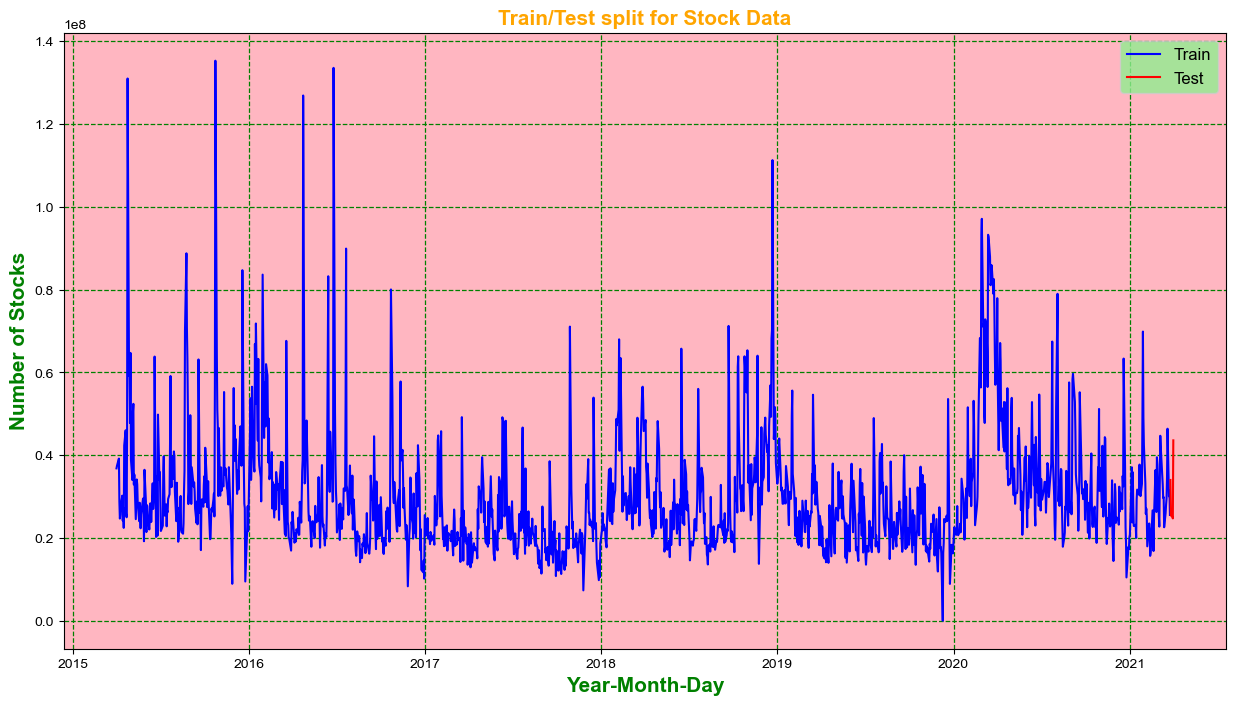

In [20]:
# plot a training and test dataset to the original dataset to predict the next few months of the stocks
microsoft_new['Date'] = microsoft_new.index
train = microsoft_new[microsoft_new['Date'] < pd.to_datetime("2021-03-25", format='%Y-%m')]
train['train'] = train['Volume']
del train['Date']
del train['Volume']
test = microsoft_new[microsoft_new['Date'] >= pd.to_datetime("2021-03-25", format='%Y-%m')]
del test['Date']
test['test'] = test['Volume']
del test['Volume']
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, color = "blue")
ax.plot(test, color = "red")
ax.set_title("Train/Test split for Stock Data", fontweight = 'bold', color = 'orange', size = 15)
ax.set_ylabel("Number of Stocks", fontweight = 'bold', color = 'green',size = 15)
ax.set_xlabel('Year-Month-Day', fontweight = 'bold', color = 'green', size = 15)
ax.set_facecolor("lightpink")
ax.legend(['Train','Test'],facecolor='lightgreen', fontsize='large' )
plt.grid(color = 'green', linestyle = '--', linewidth = 0.9)
sns.set()
plt.show()

In [21]:
# Use the ARIMA method to forecast the number of stocks with a training and test dataset
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=53004.285, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53382.888, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53223.531, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53098.615, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53380.889, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=53007.356, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53010.665, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=53010.072, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=53007.271, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53013.074, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=53004.362, Time=0.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=53009.504, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=53012.151, Time=0.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.14 sec

Best model:  ARIMA(2,1,2

Coefficients:[ 4.72025292e+06  4.85019693e-01  8.25783413e-02  7.12481327e-02
  2.04372463e-02  4.41711798e-02 -1.35437680e-02  2.55881947e-02
 -1.26584418e-02  7.49352079e-02 -3.39668943e-03  1.14645036e-03
  9.14366680e-03  3.28414114e-03  2.36616121e-02 -1.16960543e-02
 -5.96128363e-03  6.57416803e-02  6.21236727e-03 -4.19355417e-02
  1.74549286e-02]
predicted=32572469.345941, expected=31638376.000000
predicted=32195948.230559, expected=25620127.000000
predicted=30723859.558645, expected=34061853.000000
predicted=31541020.690791, expected=25479853.000000
predicted=31906293.357703, expected=25227455.000000
predicted=31988225.543686, expected=24792012.000000
predicted=31224709.785956, expected=43623471.000000
Test RMSE: 6990969.277


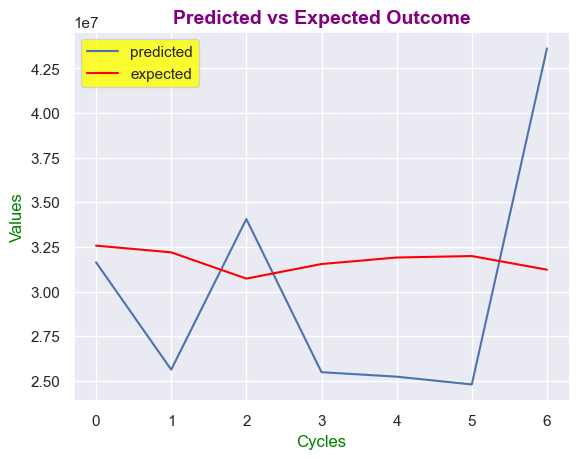

In [22]:
# calculate the RMSE and graph the predicted vs expected values 
X = microsoft.values
train, test = X[1:len(X)-7], X[len(X)-7:]
model = AutoReg(train, lags=20)
model_fit = model.fit()
print('Coefficients:%s'%model_fit.params)
predictions = model_fit.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' %(predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' %rmse)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('Predicted vs Expected Outcome', color = 'purple', fontweight = 'bold', fontsize=14)
pyplot.xlabel('Cycles', color = 'green')
pyplot.ylabel('Values', color = 'green')
pyplot.legend(labels=['predicted','expected'], facecolor = 'yellow')
pyplot.show()